In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from repositories.genotype_db import GenotypeDB
from common.phenotype_framework import PhenotypeFramework as pf
from revolve2.core.database import open_database_sqlite
from revolve2.core.optimization import DbId
from revolve2.genotypes.cppnwin.genotype_schema import DbGenotype
from revolve2.core.optimization.ea.generic_ea import (
    DbEAOptimizer,
    DbEAOptimizerGeneration,
    DbEAOptimizerIndividual,
)
from sqlalchemy.future import select

## Query DB

In [12]:
#database: str = "/home/oliver/revolve2/examples/optimize_modular/database"
database: str = "/home/oliver/Thesis/experiment/database"
db_id: DbId = DbId("optmodular")

# open the database
db = open_database_sqlite(database)
# read the optimizer data into a pandas dataframe

df = pd.read_sql(
    select(
        DbEAOptimizer,
        DbEAOptimizerGeneration,
        DbEAOptimizerIndividual,
        DbGenotype,
        GenotypeDB

    ).filter(
        (DbEAOptimizer.db_id == db_id.fullname)
        & (DbEAOptimizerGeneration.ea_optimizer_id == DbEAOptimizer.id)
        & (DbEAOptimizerIndividual.ea_optimizer_id == DbEAOptimizer.id)
        & (DbEAOptimizerIndividual.genotype_id == GenotypeDB.id)
        & (GenotypeDB.body_id == DbGenotype.id)
        & (
            DbEAOptimizerGeneration.individual_id
            == DbEAOptimizerIndividual.individual_id
        )
    ),
    db,
)

## Sandbox: Block & Hinges Plot

In [13]:
df["blocks"], df["hinges"] = zip(*df.serialized_multineat_genome.apply(pf.get_blocks_hinges_amount))

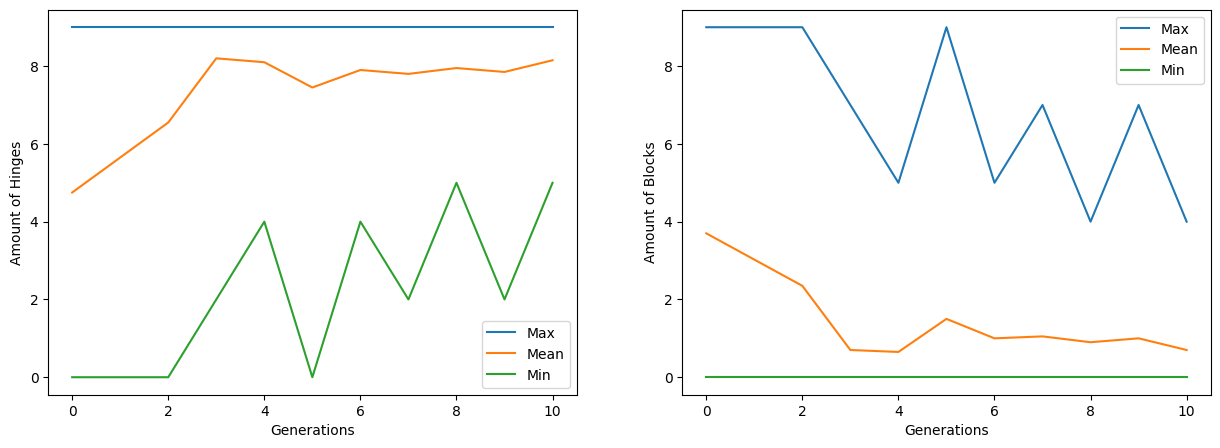

In [14]:
# calculate max min avg
hngs = (
    df[["generation_index", "hinges"]]
    .groupby(by="generation_index")
    .describe()["hinges"]
)

blcks = (
    df[["generation_index", "blocks"]]
    .groupby(by="generation_index")
    .describe()["blocks"]
)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

ax1.set_xlabel("Generations")
ax1.set_ylabel("Amount of Hinges")
ax1.plot(hngs[["max", "mean", "min"]], label= ["Max", "Mean", "Min"])
ax1.legend()

ax2.set_xlabel("Generations")
ax2.set_ylabel("Amount of Blocks")
ax2.plot(blcks[["max","mean","min"]], label= ["Max", "Mean", "Min"])
ax2.legend()
plt.savefig("plots/blocks_hinges_novelty.png", format="png")

## Sandbox: Novelty Metric

In [15]:
tests = ['yates-chi-squared', 'chi-squared', 'hellinger-dist', 'manhattan-dist', 'euclidian-dist', 'chybyshev-dist', 'pcc']
generation_groups = df[["generation_index", "serialized_multineat_genome"]].groupby(by="generation_index")
genome_groups = [data["serialized_multineat_genome"].values for _, data in generation_groups]


 Test: yates-chi-squared
runtime: 1294.23519ms
Avg STD: 0.2992654993160679

 Test: chi-squared
runtime: 1290.225101ms
Avg STD: 0.2992654993160679

 Test: hellinger-dist
runtime: 1281.266917ms
Avg STD: 0.2992654993160679

 Test: manhattan-dist
runtime: 1271.522728ms
Avg STD: 0.2992654993160679

 Test: euclidian-dist
runtime: 954.763872ms
Avg STD: 0.2992654993160679

 Test: chybyshev-dist
runtime: 780.577591ms
Avg STD: 0.2992654993160679

 Test: pcc
runtime: 780.178413ms
Avg STD: 0.2992654993160679


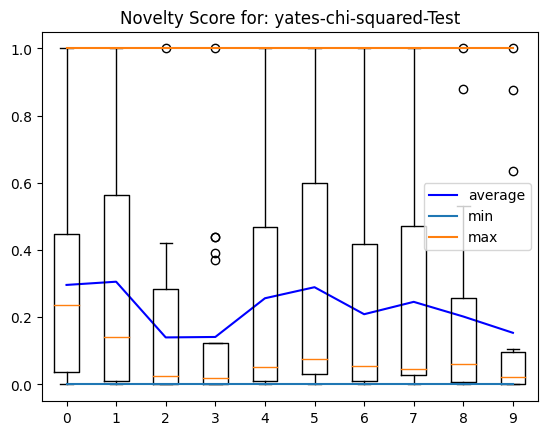

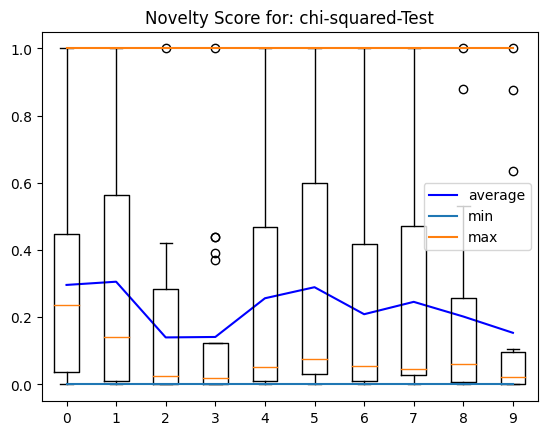

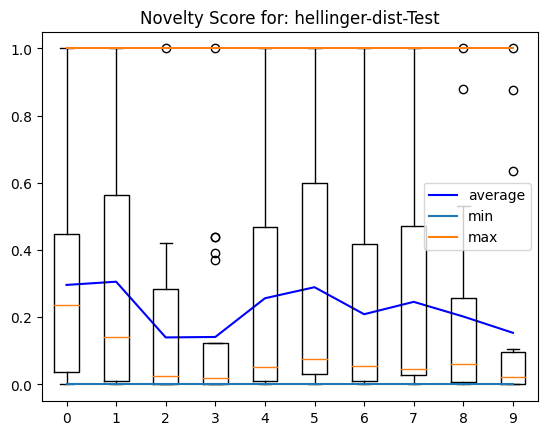

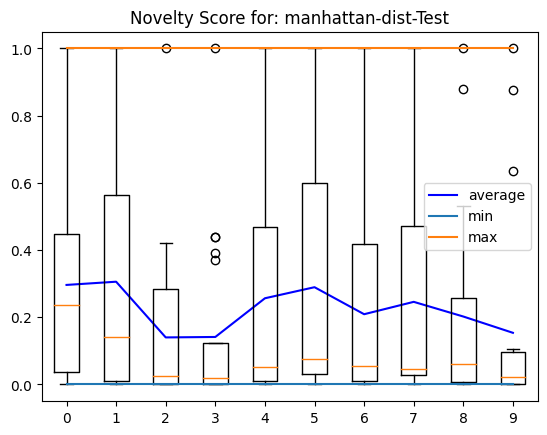

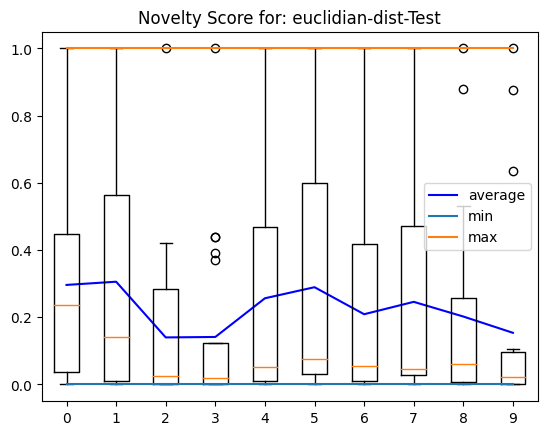

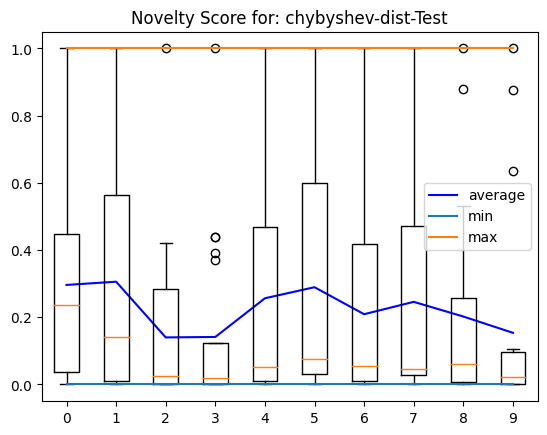

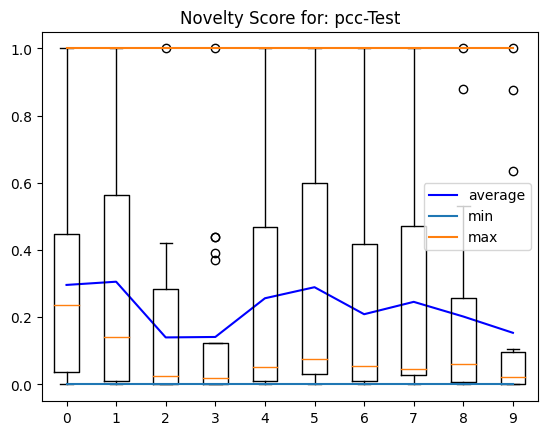

In [16]:
from numpy import std
from time import time_ns


def normalize_list(lst:list)-> list:
    vmin = min(lst)
    vmax = max(lst)
    return [(x-vmin)/(vmax-vmin) for x in lst]



for test in tests:

    print(f"\n Test: {test}")
    start = time_ns()
    data = []
    for generation in genome_groups:
        novelty_scores = pf.get_novelty_population(generation, normalization="clipping", test=test)
        data.append(normalize_list(novelty_scores))
    print(f"runtime: {(time_ns()-start)/1_000_000}ms")


    avg, vmax, vmin, vstd = [],[],[], []
    for sublist in data:
        vmax.append(max(sublist))
        vmin.append(min(sublist))
        avg.append(sum(sublist)/len(sublist))
        vstd.append(std(sublist))



    fig, ax = plt.subplots()
    ax.set_title(f"Novelty Score for: {test}-Test")
    ax.plot(avg, label="average", color="blue")
    ax.boxplot(data, positions=list(range(len(data))))

    ax.plot(vmin, label="min")
    ax.plot(vmax, label="max")
    ax.legend()
    print(f"Avg STD: {sum(vstd)/len(vstd)}")

Avg STD: 0.2992654993160679


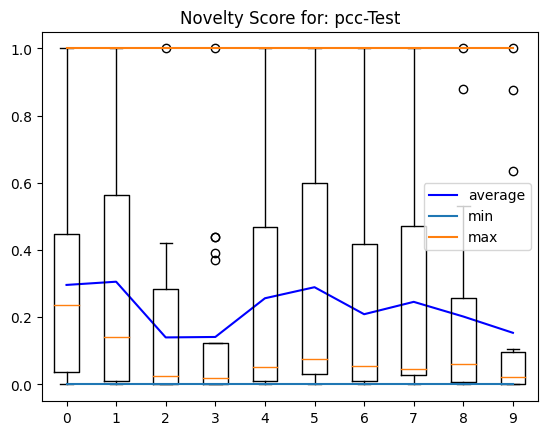

In [17]:
data = []
for generation in genome_groups:
        novelty_scores = pf.get_novelty_population(generation, normalization="clipping", test=tests[-2])
        data.append(normalize_list(novelty_scores))

avg, vmax, vmin, vstd = [],[],[], []
for sublist in data:
    vmax.append(max(sublist))
    vmin.append(min(sublist))
    avg.append(sum(sublist)/len(sublist))
    vstd.append(std(sublist))



fig, ax = plt.subplots()
ax.set_title(f"Novelty Score for: {test}-Test")
ax.plot(avg, label="average", color="blue")
ax.boxplot(data, positions=list(range(len(data))))

ax.plot(vmin, label="min")
ax.plot(vmax, label="max")
ax.legend()
print(f"Avg STD: {sum(vstd)/len(vstd)}")

plt.savefig("plots/novelty_scores_novelty_chybyshev.png", format="png")